# Overview of the steps this code will take:
### 1. load in the data
### 2. convert data for training
### 3. perform train_test_split
### 4. fit the training data to the lda
### 5. plot the confusion matrix
### 6. get analysis of the fit
### 7. fit the unknown species

In [1]:
#import libaries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import function to construct a train/test split of the data
from sklearn.model_selection import train_test_split
#import function to construct a confusion matrix 
from sklearn.metrics import confusion_matrix
#import methods to run LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#import function to get precision,recall, F1 score given true labels y and predicted labels y_pred
from sklearn.metrics import precision_recall_fscore_support
#import function to find the standardization factor of a given set of numbers
from sklearn.preprocessing import StandardScaler
#import thisto do resampling
from sklearn.utils import resample
#import seaborn for plotting
import seaborn as sns
import os
%matplotlib inline

After importing all the necessary packages, load in the data as a csv. 
This file contains all the x,y points for each of the species

In [2]:
#read in the data
df = pd.read_csv('procrustes_all.csv')

#set the name of prediction type (column name): species, year, from_tip, from_base
label_name = 'species'

#set the name of prediction type for graphing purposes (not column name)
print_label = label_name

In order to ensure that all the species have equal representation in our test, we are going to upsample (with resample) the speceis data. So this means that all the species will have the same number of objects, and the ones that were upsampled are also randomly sampled. In this case, all the species will have 2955 objects. 

However we also want to mask out the Vitis hybrids and unknown species to be removed from this dataset. Because this data is going to be used to make the model, we dont want unknown species to be part of it. We will add them back in later to test how our model works. 

In [3]:
#set parameters

#set this to true to allow upsampling. Note resample needs to be true also. 
upsample = True

#set this to true to mask (filter out) the hybrid species for training LDA
mask_hybrids = True

#set this to true to mask Vitis_spp
mask_Vitis_spp = True

#set cutoff value to upsample minority classes
#any class with fewer obs. than this will be upsampled to have this many obs. Riperia is the most sampled at 2955
minority_cutoff = 2955

In [4]:
#this masks the hybrid species (for species pred. only)
if mask_hybrids == True:
    #get the a unique list of the hybrid species
    hybrids = df.species[df.species.str.contains("_x_")].unique()
    #find hybrid obs. 
    hybrid_mask = df.species.isin(hybrids.tolist())
    #mask the hybrid obs. 
    df = df[~hybrid_mask]

#this masks the Vitis_spp (for species pred. only)
if mask_Vitis_spp == True:
    #find Vitis_spp obs.
    Vitis_spp_mask = (df.species == 'Vitis_spp')
    #mask Vitis_spp
    df = df[~Vitis_spp_mask]

In [5]:
# get counts of observations of each class
class_cnts = df[label_name].value_counts()

#do upsampling 
if upsample == True:
    #find minority classes
    minority_class = class_cnts[class_cnts < minority_cutoff].index
        
    #remove the minority class data from the data frame
    #will put the resampled data from these classes back in
    data_resampled=df[~df[label_name].isin(minority_class)]
    
    #upsample each species below the minority cutoff
    for s in minority_class:
        # Separate minority class
        data_minority = df[df[label_name] == s]
        # Upsample minority specie
        data_minority_upsampled = resample(data_minority, 
                                         replace=True,     # sample with replacement
                                         n_samples=minority_cutoff,    # to match majority class
                                         random_state=40) # reproducible results
        #concat each upsampled minority obs. into one dataframe
        data_resampled = pd.concat([data_resampled,data_minority_upsampled])
    #set the main df now to the data of upsampled class obs., and the non-upsampled original obs.  
    df = data_resampled

We need to format the data correctly for the train_test_split function. This involves dropping the first columns that do not contain the X,Y corrdinates and making a new df to put the newly computed variables in. Then we will run the function.

Train_test_split we have set for 80% of our data randomized for training, and the other 20% will be tested against the training set. This split ratio is arbitrary, but conventional. If the training set was less the model could be overfitted, and if it was more the model would be underfitted. 

In [6]:
 #we need to make a list of columns for the next cell, since there are too many to type by hand. 
    #However we only want the x and y columns, so we first drop the first 4 columns.
xy_df = df.drop(columns = ['vine', 'vine_year', 'year', 'species'])
xy_column_list = xy_df.columns

In [7]:
#set the input (X) and target data (y)
X=df[xy_column_list]
y=df[[label_name]]

#put prediction values in proper format for learning process
y=y.values
y=y.flatten()

#set the unique class labels
classes = np.unique(y)

#convert to string if needed (for integers etc.)
y=list(map(str, y))
classes = list(map(str,classes))

#define the data split for training and testing. This will be for the confusion matrix only. 
#we will use cross validation for the other performance metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardize the both the training and test data using the training standard scalar
sc = StandardScaler()
#get standardizing factor of the training data variables, and then standardize
X_train = sc.fit_transform(X_train)
#apply same transformation to the test data
X_test = sc.transform(X_test)

Now its time to fit the trained data to the LDA.

"A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule. The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix. The fitted model can also be used to reduce the dimensionality of the input by projecting it to the most discriminative directions."

-- https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

In [8]:
# set and initialize the LDA model
lda  = LinearDiscriminantAnalysis(n_components=4)

#fit the training data, i.e. find mapping between training coordinates and training species
lda_fit = lda.fit(X_train, y_train)

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Now we can visualize this LDA using a confusion matrix. We can also calculate how well the training data did against our training set (the miscalculation rate).

In [9]:
#find the predicted class labels on the testing data
y_pred=lda.predict(X_test)

#get confusion matrix for the test predictions
cm=confusion_matrix(y_test, y_pred, labels=classes)

n_class=cm.shape[0]
miss_classify_rate_list=[] # the miss-classification rate for each species

for i in range(n_class):
    miss_classify_rate_list.append(round(1-(cm[i,i]/cm[i,:].sum()),3))

# find the species whose miss-classification rate larger than 0.001
idx_miss=np.array(miss_classify_rate_list)>0.001
classes_miss=np.array(classes)[idx_miss]
rate_miss=np.array(miss_classify_rate_list)[idx_miss]

# creat a DataFrame showing the species whose mis-classfication rate is bigger than 0.5
miss_classified=pd.DataFrame({'misclassified species': classes_miss, 'Percentage of misclassification': rate_miss})
miss_classified

,misclassified species,Percentage of misclassification
0,Vitis_acerifolia,0.502
1,Vitis_aestivalis,0.426
2,Vitis_amurensis,0.259
3,Vitis_cinerea,0.313
4,Vitis_coignetiae,0.237
5,Vitis_labrusca,0.345
6,Vitis_palmata,0.159
7,Vitis_riparia,0.512
8,Vitis_rupestris,0.240
9,Vitis_vulpina,0.237


And then we can plot the confusion matrix

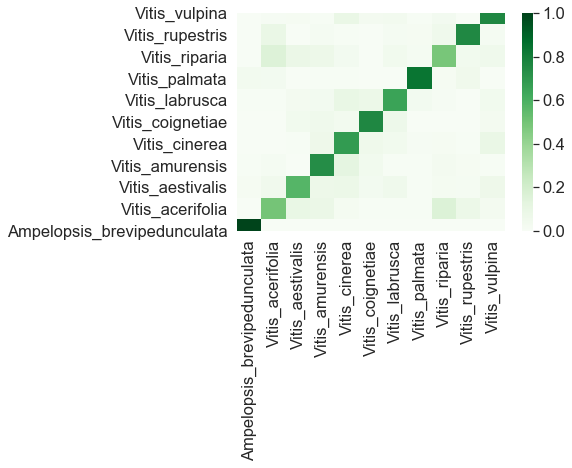

<Figure size 1800x1800 with 0 Axes>

In [11]:
#this makes the confusion matrix into percentage of a true class, classified as each class
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#output confusion matrix heatmap showing the percentage of each class prediction for a given true class, 
#over all true class observations 

x_axis_labels =  classes # labels for x-axis
y_axis_labels = np.flip(classes, axis=0) # labels for y-axis
ax = sns.heatmap(np.flipud(cm_norm), cmap="Greens", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
#here i used cm to create the heatmap
sns.set(font_scale=1.5)
plt.figure(figsize=(25, 25))

figure = ax.get_figure()

We can calculate the precision, accuracy, recall, and F1 of our training set. 

In [12]:
#set number of unique classes
num_classes=len(np.unique(y))

#set num of folds, this may take some time. 
folds=1000

#this keeps track of how many times each class was in a test set throughout the k-fold crossvalidation
fold_count = np.zeros(num_classes)
#this gets sets an array with all the indices corresponding to the unique classes
#we'll refer to this below
idx = np.array(list(range(num_classes)))

#initialize performance metric arrays to hold the 
#respective values for each class
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1_score = np.zeros(num_classes)
accuracy_scores = np.zeros(num_classes)

for i in range(folds):
    #define the data split for training and testing 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=i)
    
    #standardize the both the training and test data using the training standard scalar
    sc = StandardScaler()
    #get standardizing factor of the training data variables, and then standardize
    X_train = sc.fit_transform(X_train)
    #apply same transformation to the test data
    X_test = sc.transform(X_test)

    # set and initialize the LDA model
    lda  = LinearDiscriminantAnalysis(n_components=4)
    #fit the model on the training data for these k-1 folds
    lda_fit = lda.fit(X_train, y_train)
    #make predictions on the test fold
    y_pred=lda.predict(X_test)
    
    #find precision, recall, and f1 score
    P=precision_recall_fscore_support(y_test,y_pred, labels = classes)
    
    #if any of the performance metrics are nan, set to zero 
    P[0][np.isnan(P[0])] = 0.0
    P[1][np.isnan(P[1])] = 0.0
    P[2][np.isnan(P[2])] = 0.0
    
    #sum the performane metrics so after crossvalidation we can get an average performance value
    precision+=P[0]
    recall+=P[1]
    f1_score+=P[2]
    
    #get confusion matrix for the test predictions
    cm=confusion_matrix(y_test,y_pred, labels=classes)
    
    #convert to percentage classified 
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    #here accuracy for each class is the percentage of a given class 
    #that were correctly identified, i.e. TP / P = TP / (TP+FN)
    acc=np.array(np.diag(cm_norm))
    acc[np.isnan(acc)]=0.0
    accuracy_scores += acc
    

    #find which classes are not in the test set
    #in these cases the precision_recall_fscore_support function 
    #simply sets the performance metrics to zero
    missing_classes = set(y) - set(y_test)
    
    #find the indices corresponding to the missing classes
    missing_idx = np.where(np.isin(classes,list(missing_classes)))
    
    #get non_missing indices 
    update_idx = np.delete(idx, missing_idx)
    
    #update the fold count (add 1 each time) only for the classes that were actually
    #in the test set. 
    #e.g. if a class was not in the test set 3 of the 10 times we should not be dividing by k=10 
    #when averaging the performance metrics, but rather divide by 7.  
    fold_count[update_idx] += 1.0

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Abigail Bryson\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

In [13]:
#now average the scores for the 10 folds
precision /= fold_count
recall /= fold_count
f1_score /= fold_count
accuracy_scores /= fold_count

#define performance table with precsision, recall, and f1
performance_tbl = pd.DataFrame({'Class': classes, 'Precision': precision, 'Recall': recall, 'accuracy': accuracy_scores, 'F1': f1_score} )
#save this as an excel for later use:
performance_tbl.to_csv('ALL_Species_LDA.csv')
performance_tbl

,Class,Precision,Recall,accuracy,F1
0,Ampelopsis_brevipedunculata,0.925830,1.000000,1.000000,0.961429
1,Vitis_acerifolia,0.572286,0.500616,0.500616,0.533573
2,Vitis_aestivalis,0.680361,0.564469,0.564469,0.616583
3,Vitis_amurensis,0.648717,0.730006,0.730006,0.686589
4,Vitis_cinerea,0.588795,0.692592,0.692592,0.636103
5,Vitis_coignetiae,0.735129,0.766282,0.766282,0.750053
6,Vitis_labrusca,0.667919,0.648108,0.648108,0.657485
7,Vitis_palmata,0.854831,0.836762,0.836762,0.845461
8,Vitis_riparia,0.583604,0.506808,0.506808,0.542020
9,Vitis_rupestris,0.761869,0.732396,0.732396,0.746519


# Now time to test using the stuff we masked out before

## Add Vitis_spp + Vitis_hybrids

First we will format the data. We 2 sets of data: one with the x and y values for all the species labeled 'spp', and antoher with the x and y values for all the Vitis hybrids.

In [14]:
#read in the orgiginal dataset once again to make sure to use the right data
df=pd.read_csv('procrustes_all.csv')

#make masks for the spp and make a dataframe of just those data
df_spp = df[df['species'] == 'Vitis_spp']

#drop the first 4 columns so we only have x and y points for each of the rows.
X_spp = df_spp.drop(columns = ['vine', 'vine_year', 'year', 'species'])

#only want the row of species that has _X_ in the name, since thats how the hybrids are called
hybrid_mask = df['species'].str.contains('_x_')

#put the mask on the df so that its only the rows of hybrids
hybrids = df[hybrid_mask]

#drop the first 4 columns so we only have x and y points for each of the rows.
X_Vitis_x_ = hybrids.drop(columns = ['vine', 'vine_year', 'year', 'species'])

Now we can fit our new unknown data to the model we created earlier. We can add the spp and hybrids as rows to the confusion matrix.

In [18]:
X_spp = sc.transform(X_spp)       #normalize coordinates by using the same transform applied to training data 
y_pred_spp = lda.predict(X_spp)   #predict Vitis_spp

X_Vitis_x_ = sc.transform(X_Vitis_x_)   # normalize coordinates by using the same transform applied to training data 
y_pred_Vitis_x_=lda.predict(X_Vitis_x_)  #predict Vitis_hybrids


# count the classification results
n_list_spp=[] # the number of each class in the prediction results
for name in classes:
    n_list_spp.append(np.sum(y_pred_spp == name))
    
n_list_hybrid=[] # the number of each class in the prediction results
for name in classes:
    n_list_hybrid.append(np.sum(y_pred_Vitis_x_ == name))
    

# plot confusion matrix with vitis_spp added 
cm_spp = np.append(cm, np.array(n_list_spp)[None,...], axis=0) # add prediction of vitis_spp in the last row
# add that to hybrids too 
cm_spp_x = np.append(cm_spp, np.array(n_list_hybrid)[None,...], axis=0) # add prediction of vitis_spp in the last row


classes_spp = np.append(classes,'Vitis_spp')
classes_spp_x = np.append(classes_spp,'Vitis_hybrid')

cm_spp_x=cm_spp_x.astype(float)
# normalized confusion matrix
for i in range(cm_spp_x.shape[0]):
    cm_spp_x[i,:]=cm_spp_x[i,:]/cm_spp_x[i,:].sum()
    
# creat a DataFrame showing the new species classification
spp_classified=pd.DataFrame({'Spp New Classification': classes, 'Number': n_list_spp})
spp_classified.to_csv('Classification_spp_ALL_Species_LDA.csv')
print(spp_classified)
hybrids_classified=pd.DataFrame({'Hybrid New Classification': classes, 'Number': n_list_hybrid})
hybrids_classified.to_csv('Classification_hybrids_ALL_Species_LDA.csv')
print(hybrids_classified)

         Spp New Classification  Number
0   Ampelopsis_brevipedunculata     195
1              Vitis_acerifolia       0
2              Vitis_aestivalis      28
3               Vitis_amurensis      54
4                 Vitis_cinerea       0
5              Vitis_coignetiae       2
6                Vitis_labrusca       0
7                 Vitis_palmata      13
8                 Vitis_riparia       0
9               Vitis_rupestris       0
10                Vitis_vulpina     234
      Hybrid New Classification  Number
0   Ampelopsis_brevipedunculata      60
1              Vitis_acerifolia       0
2              Vitis_aestivalis       4
3               Vitis_amurensis      12
4                 Vitis_cinerea       0
5              Vitis_coignetiae       5
6                Vitis_labrusca       0
7                 Vitis_palmata       6
8                 Vitis_riparia       0
9               Vitis_rupestris       0
10                Vitis_vulpina      58


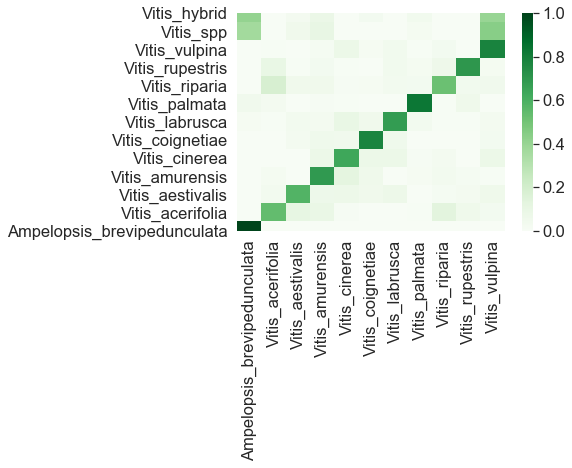

<Figure size 1800x1800 with 0 Axes>

In [19]:
x_axis_labels =  classes # labels for x-axis
y_axis_labels = np.flip(classes_spp_x, axis=0) # labels for y-axis
ax = sns.heatmap(np.flipud(cm_spp_x), cmap="Greens", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
#here i used cm to create the heatmap
sns.set(font_scale=1.5)
plt.figure(figsize=(25, 25))

figure = ax.get_figure()

#uncomment the code below to save the figure
#plt.savefig('Final_LDA_ALL_Species.tif', bbox_inches="tight", dpi=600)

The End. 